# CSC8499 Project and Dissertation:

# Twitter Spam Detection                                          

## Name: KAILASH BALACHANDIRAN
## Student ID: 220243160

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import warnings
import pickle
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import recall_score, f1_score, precision_score
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kailashbalachandiran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kailashbalachandiran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kailashbalachandiran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#Read data
df = pd.read_csv("data.csv")

In [3]:
print(df.head(10))

                                               Tweet     Type
0  It's the everything else that's complicated. #...  Quality
1  Eren sent a glare towards Mikasa then nodded a...  Quality
2  I posted a new photo to Facebook http://fb.me/...  Quality
3  #jan Idiot Chelsea Handler Diagnoses Trump Wit...     Spam
4  Pedophile Anthony Weiner is TERRIFIED of Getti...     Spam
5  EBMUD ending penalties for excessive water use...     Spam
6  Big day.  #WeTheNorth #yyz #thesix #sunset #sk...  Quality
7  #UPA #scams to the tune of Rs 12 lakh Crore #S...  Quality
8  **MISSING**\nA male tabby cat has gone missing...  Quality
9  Paraguayan man linked to Hezbollah faces drug ...     Spam


In [4]:
print(df.shape)

(11968, 2)


In [5]:
df = df.drop_duplicates()
print(df.shape)
print(df.isnull().sum())

(11787, 2)
Tweet    0
Type     0
dtype: int64


In [6]:
df = df.dropna()
print(df.isnull().sum())
print(df['Type'].unique())

Tweet    0
Type     0
dtype: int64
['Quality' 'Spam']


In [7]:
# count of Quality and spam
df['Type'].value_counts()

Quality    5983
Spam       5804
Name: Type, dtype: int64

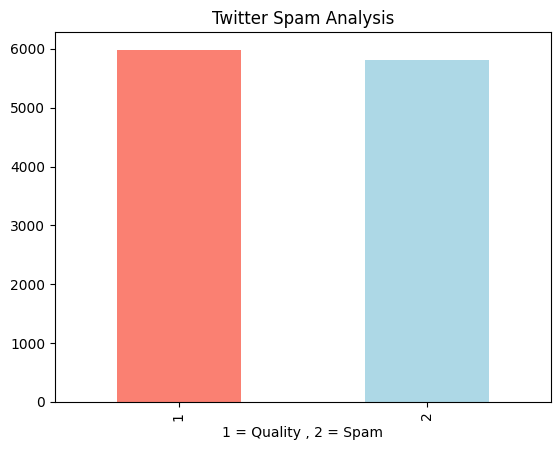

In [8]:
dictionary={'Quality':1,'Spam':2}
df['Type']=df['Type'].map(dictionary)

#plotting the graph
df["Type"].value_counts().plot(kind="bar", color=["salmon","lightblue"])
plt.xlabel("1 = Quality , 2 = Spam")
plt.title("Twitter Spam Analysis")
plt.show()

In [9]:
# Separate spam and real tweets
real_tweets = df[df['Type'] == 1]

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Join spam and real tweets into a single text for word cloud generation
real_text = ' '.join(real_tweets['Tweet'])

# Generate word clouds for spam and real tweets
generate_word_cloud(real_text, 'Word Cloud for Real Tweets')


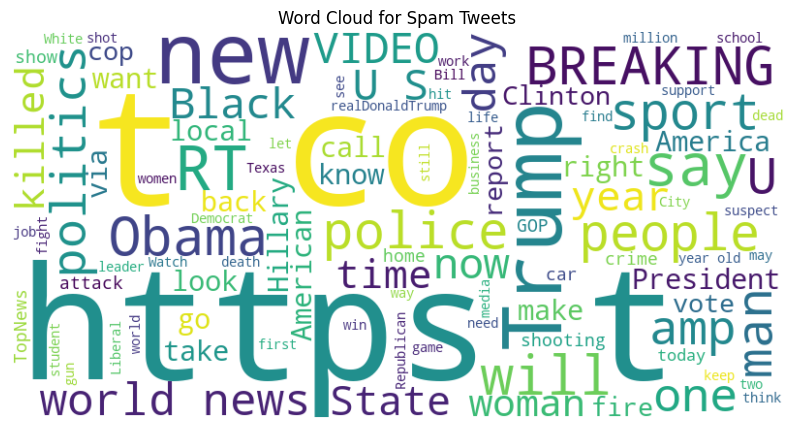

In [10]:
# Separate spam and real tweets
spam_tweets = df[df['Type'] == 2]

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Join spam and real tweets into a single text for word cloud generation
spam_text = ' '.join(spam_tweets['Tweet'])

# Generate word clouds for spam and real tweets
generate_word_cloud(spam_text, 'Word Cloud for Spam Tweets')

In [11]:
#Cleaning and pre-processing the data
#Remove punctuations from the string
s = "!</> hello please$$ </>^!!!%%&&%$@@@attend^^^&&!& </>*@# the&&\ @@@class##%^^&!@# %%$"
s = re.sub(r'[^\w\s]','',s)
print(s)          

 hello please attend  the class 


In [12]:
#Tokenization
k=nltk.word_tokenize("Hello how are you")
print(k)

['Hello', 'how', 'are', 'you']


In [13]:
#StopWords
stop_words = stopwords.words('english')
print(stop_words)

sentence = "Covid-19 pandemic has impacted many countries and what it did to economy is very stressful"

words = nltk.word_tokenize(sentence)
words = [w for w in words if w not in stop_words]

print(words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
#Lemmatization
#It helps in returing the base or dictionary form of a word known as the lemma
lemmatizer=WordNetLemmatizer()


input_str = "been had done languages cities mice"

In [15]:
#Tokenize the sentence
input_str=nltk.word_tokenize(input_str)

In [16]:
#Lemmatize each word
for word in input_str:
    print(lemmatizer.lemmatize(word))

been
had
done
language
city
mouse


In [17]:
for index,row in df.iterrows():
    filter_sentence = ''
    
    sentence = row['Tweet']
    
    sentence = re.sub(r'[^\w\s]','',sentence) #cleaning
    
    words = nltk.word_tokenize(sentence) #tokenization
    
    words = [w for w in words if not w in stop_words] #stopwords removal 
    
    for word in words:
        filter_sentence = filter_sentence + ' ' + str(lemmatizer.lemmatize(word)).lower()
    
    #print(filter_sentence)
    df.loc[index,'Tweet'] = filter_sentence
    
print(df.head())

                                               Tweet  Type
0   its everything else thats complicated pesummi...     1
1   eren sent glare towards mikasa nodded stood g...     1
2      i posted new photo facebook httpfbme2be7liyuj     1
3   jan idiot chelsea handler diagnoses trump wit...     2
4   pedophile anthony weiner terrified getting be...     2


In [18]:
X = df['Tweet']
y = df['Type']
print(X)
print(y)

0         its everything else thats complicated pesummi...
1         eren sent glare towards mikasa nodded stood g...
2            i posted new photo facebook httpfbme2be7liyuj
3         jan idiot chelsea handler diagnoses trump wit...
4         pedophile anthony weiner terrified getting be...
                               ...                        
11963                                      1111 meet harry
11964     if bbc food disappears loss knowledge catastr...
11965     look what liberals did this historic monument...
11966     i uploaded new track everyday lite 1 spreaker...
11967     trump declared victor 945 tonight based exit ...
Name: Tweet, Length: 11787, dtype: object
0        1
1        1
2        1
3        2
4        2
        ..
11963    1
11964    1
11965    2
11966    1
11967    2
Name: Type, Length: 11787, dtype: int64


In [19]:
#split in samples
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =0)

print('X_train :', len(X_train))
print('X_test :', len(X_test))
print('y_train :', len(y_train))
print('y_test :', len(y_test))

X_train : 9429
X_test : 2358
y_train : 9429
y_test : 2358


In [20]:
#Naive Bayes classifier

clf1 = MultinomialNB()

In [21]:
model1 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm='l2')), ('clf', clf1),])

In [22]:
model1.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [23]:
predictions1 = model1.predict(X_test)

In [24]:
accuracy=accuracy_score(y_test,predictions1)

print("Accuracy of Naive Bayes is {:.2f}%".format(accuracy*100))

Accuracy of Naive Bayes is 81.64%


In [25]:
final_model = '/Users/kailashbalachandiran/Library/CloudStorage/OneDrive-NewcastleUniversity/Course works/CSC8499/Twitter_Spam_Detection/final_pickle_model.pkl'
pickle.dump(model1,open(final_model,'wb'))

In [26]:
pred_model = pickle.load(open(final_model,'rb'))
pred = pred_model.predict(X_test)
accuracy=accuracy_score(y_test,pred)
print("Accuracy of the final model is {:.2f}%".format(accuracy*100))

Accuracy of the final model is 81.64%


In [27]:
# Map y_test to numerical labels (1 for Quality, 2 for Spam)
label_map = {1: 'Quality', 2: 'Spam'}
y_test_binary = np.vectorize(label_map.get)(y_test)

# Get the classification report as a string
class_report_str = classification_report(y_test_binary, pd.Series(predictions1).map(label_map), target_names=['Quality', 'Spam'])

# Parse the classification report and store the metrics in a DataFrame
class_report_dict = classification_report(y_test_binary, pd.Series(predictions1).map(label_map), target_names=['Quality', 'Spam'], output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report for Naive Bayes Model')
plt.show()



Classification Report - Naive Bayes:
              precision    recall  f1-score   support

        Real       0.81      0.82      0.82      1164
        Fake       0.82      0.81      0.82      1194

    accuracy                           0.82      2358
   macro avg       0.82      0.82      0.82      2358
weighted avg       0.82      0.82      0.82      2358

Confusion Matrix - Naive Bayes:
[[957 207]
 [226 968]]




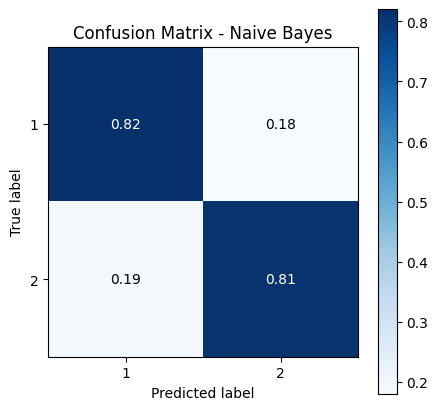

In [28]:
# List of model names
model_names = ['Naive Bayes']

# List of predictions for each model
predictions = [predictions1]

# Loop over each model's predictions and generate the classification report and confusion matrix
for model_name, prediction in zip(model_names, predictions):
    print(f'Classification Report - {model_name}:')
    print(classification_report(y_test, prediction, target_names=['Real', 'Fake']))
    
    print(f'Confusion Matrix - {model_name}:')
    cm = confusion_matrix(y_test, prediction)
    print(cm)
    print('\n')
    
    # Visualize the confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True, figsize=(5, 5))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


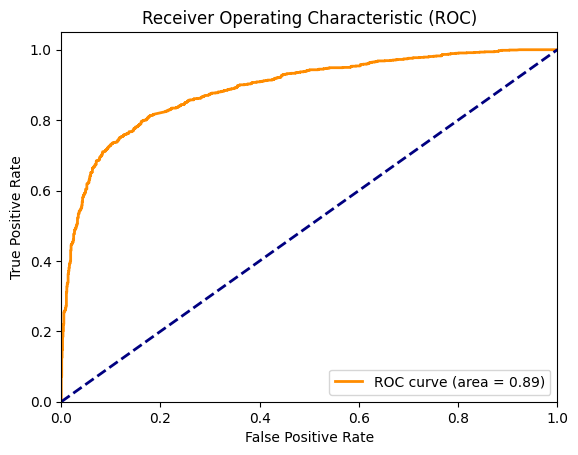

In [29]:
# Convert the y_test labels to {0, 1} format
y_test_binary = (y_test == 2).astype(int)

# Get the predicted probabilities for class 2 (Spam)
predicted_probs = model1.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [30]:
clf2 = LogisticRegression()

In [31]:
model2 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm='l2')), ('clf', clf2),])

In [32]:
model2.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

In [33]:
predictions2 = model2.predict(X_test)

In [34]:
accuracy=accuracy_score(y_test,predictions2)

print("Accuracy of Logistic Regression is {:.2f}%".format(accuracy*100))

Accuracy of Logistic Regression is 80.79%


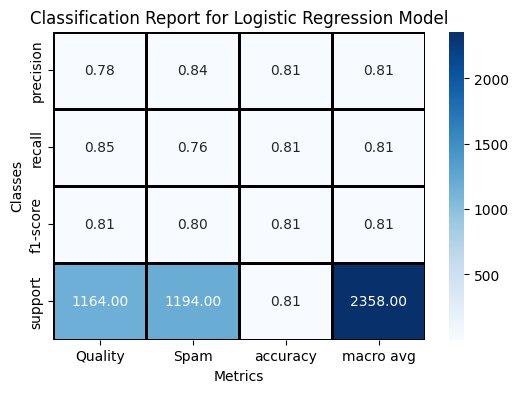

In [35]:
# Map y_test to numerical labels (1 for Quality, 2 for Spam)
label_map = {1: 'Quality', 2: 'Spam'}
y_test_binary = np.vectorize(label_map.get)(y_test)

# Get the classification report as a string
class_report_str = classification_report(y_test_binary, pd.Series(predictions2).map(label_map), target_names=['Quality', 'Spam'])

# Parse the classification report and store the metrics in a DataFrame
class_report_dict = classification_report(y_test_binary, pd.Series(predictions2).map(label_map), target_names=['Quality', 'Spam'], output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report for Logistic Regression Model')
plt.show()

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

        Real       0.78      0.85      0.81      1164
        Fake       0.84      0.76      0.80      1194

    accuracy                           0.81      2358
   macro avg       0.81      0.81      0.81      2358
weighted avg       0.81      0.81      0.81      2358

Confusion Matrix - Logistic Regression:
[[995 169]
 [284 910]]




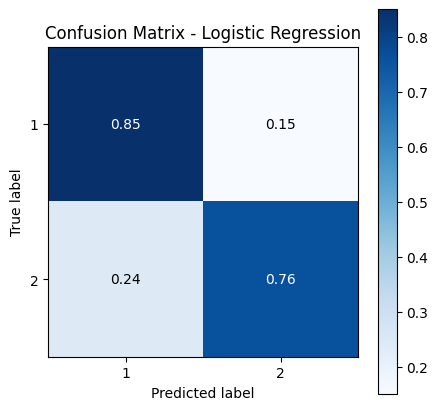

In [36]:
# List of model names
model_names = ['Logistic Regression']

# List of predictions for each model
predictions = [predictions2]

# Loop over each model's predictions and generate the classification report and confusion matrix
for model_name, prediction in zip(model_names, predictions):
    print(f'Classification Report - {model_name}:')
    print(classification_report(y_test, prediction, target_names=['Real', 'Fake']))
    
    print(f'Confusion Matrix - {model_name}:')
    cm = confusion_matrix(y_test, prediction)
    print(cm)
    print('\n')
    
    # Visualize the confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True, figsize=(5, 5))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

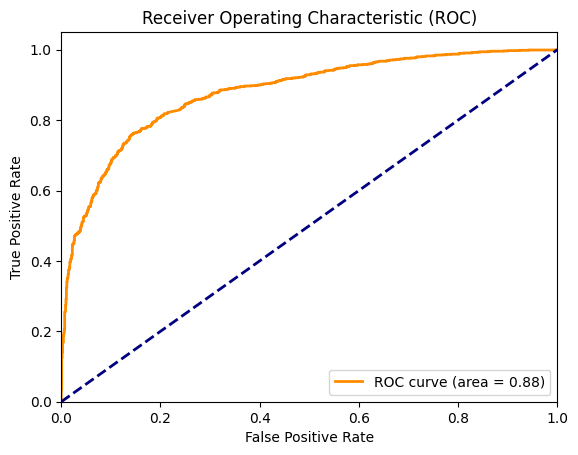

In [37]:
# Convert the y_test labels to {0, 1} format
y_test_binary = (y_test == 2).astype(int)

# Get the predicted probabilities for class 2 (Spam)
predicted_probs = model2.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [38]:
clf3 = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)

In [39]:
model3 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm='l2')), ('clf', clf3),])

In [40]:
model3.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(n_estimators=400))])

In [41]:
predictions3 = model3.predict(X_test)

In [42]:
accuracy=accuracy_score(y_test,predictions3)

print("Accuracy of XGB Classifiers is {:.2f}%".format(accuracy*100))

Accuracy of XGB Classifiers is 75.61%


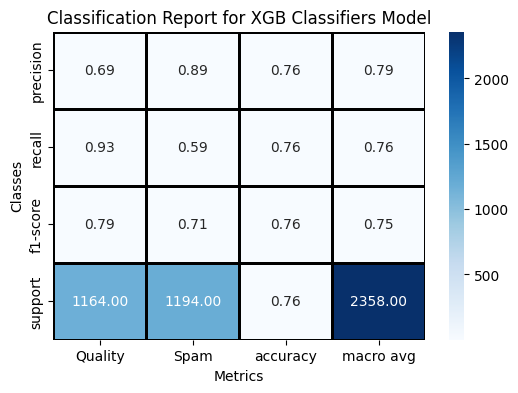

In [43]:
# Map y_test to numerical labels (1 for Quality, 2 for Spam)
label_map = {1: 'Quality', 2: 'Spam'}
y_test_binary = np.vectorize(label_map.get)(y_test)

# Get the classification report as a string
class_report_str = classification_report(y_test_binary, pd.Series(predictions3).map(label_map), target_names=['Quality', 'Spam'])

# Parse the classification report and store the metrics in a DataFrame
class_report_dict = classification_report(y_test_binary, pd.Series(predictions3).map(label_map), target_names=['Quality', 'Spam'], output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report for XGB Classifiers Model')
plt.show()

Classification Report - XGB Classifier:
              precision    recall  f1-score   support

        Real       0.69      0.93      0.79      1164
        Fake       0.89      0.59      0.71      1194

    accuracy                           0.76      2358
   macro avg       0.79      0.76      0.75      2358
weighted avg       0.79      0.76      0.75      2358

Confusion Matrix - XGB Classifier:
[[1079   85]
 [ 490  704]]




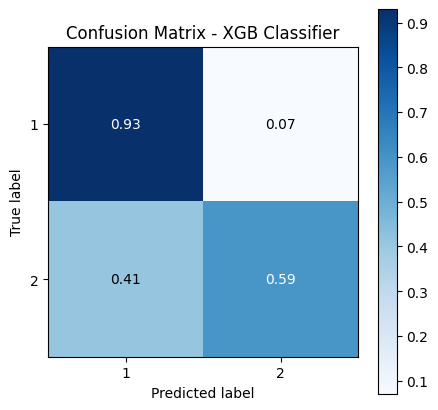

In [44]:
# List of model names
model_names = ['XGB Classifier']

# List of predictions for each model
predictions = [predictions3]

# Loop over each model's predictions and generate the classification report and confusion matrix
for model_name, prediction in zip(model_names, predictions):
    print(f'Classification Report - {model_name}:')
    print(classification_report(y_test, prediction, target_names=['Real', 'Fake']))
    
    print(f'Confusion Matrix - {model_name}:')
    cm = confusion_matrix(y_test, prediction)
    print(cm)
    print('\n')
    
    # Visualize the confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True, figsize=(5, 5))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

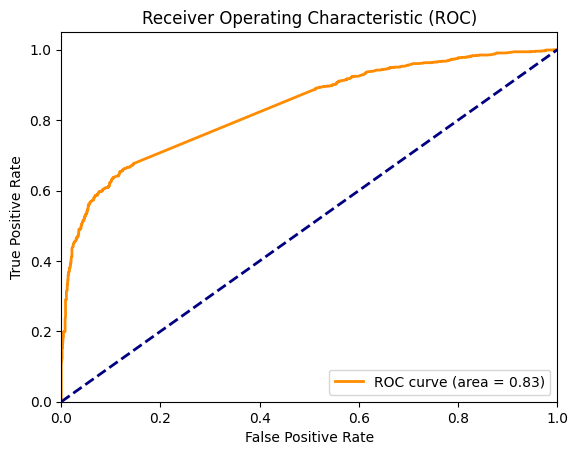

In [45]:
# Convert the y_test labels to {0, 1} format
y_test_binary = (y_test == 2).astype(int)

# Get the predicted probabilities for class 2 (Spam)
predicted_probs = model3.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [46]:
clf4 = RandomForestClassifier(n_estimators=400)

In [47]:
model4 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm='l2')), ('clf', clf4),])

In [48]:
model4.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=400))])

In [49]:
predictions4 = model4.predict(X_test)

In [50]:
accuracy=accuracy_score(y_test,predictions4)

print("Accuracy of RandomForestClassifier is {:.2f}%".format(accuracy*100))

Accuracy of RandomForestClassifier is 78.84%


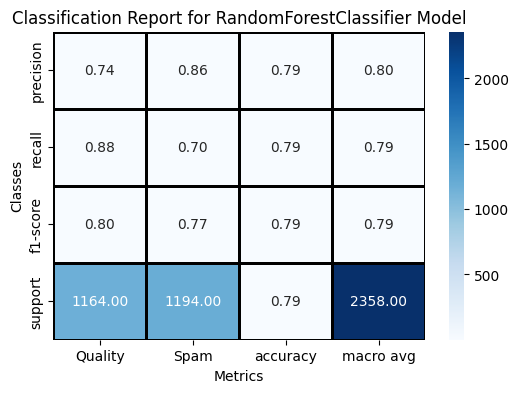

In [51]:
# Map y_test to numerical labels (1 for Quality, 2 for Spam)
label_map = {1: 'Quality', 2: 'Spam'}
y_test_binary = np.vectorize(label_map.get)(y_test)

# Get the classification report as a string
class_report_str = classification_report(y_test_binary, pd.Series(predictions4).map(label_map), target_names=['Quality', 'Spam'])

# Parse the classification report and store the metrics in a DataFrame
class_report_dict = classification_report(y_test_binary, pd.Series(predictions4).map(label_map), target_names=['Quality', 'Spam'], output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report for RandomForestClassifier Model')
plt.show()

Classification Report - RandomForestClassifier:
              precision    recall  f1-score   support

        Real       0.74      0.88      0.80      1164
        Fake       0.86      0.70      0.77      1194

    accuracy                           0.79      2358
   macro avg       0.80      0.79      0.79      2358
weighted avg       0.80      0.79      0.79      2358

Confusion Matrix - RandomForestClassifier:
[[1027  137]
 [ 362  832]]




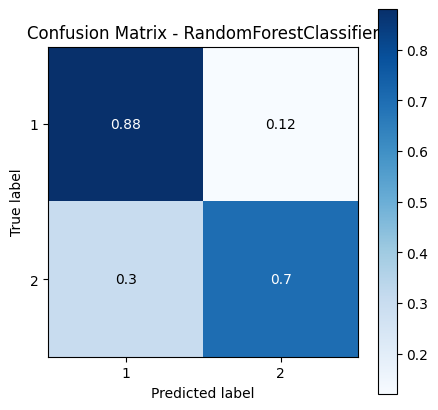

In [52]:
# List of model names
model_names = ['RandomForestClassifier']

# List of predictions for each model
predictions = [predictions4]

# Loop over each model's predictions and generate the classification report and confusion matrix
for model_name, prediction in zip(model_names, predictions):
    print(f'Classification Report - {model_name}:')
    print(classification_report(y_test, prediction, target_names=['Real', 'Fake']))
    
    print(f'Confusion Matrix - {model_name}:')
    cm = confusion_matrix(y_test, prediction)
    print(cm)
    print('\n')
    
    # Visualize the confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True, figsize=(5, 5))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

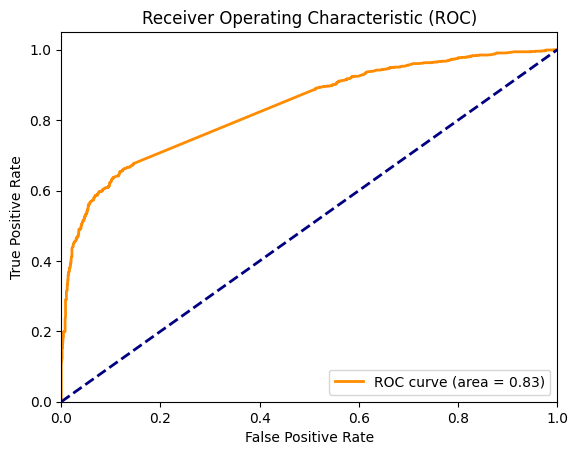

In [53]:
# Convert the y_test labels to {0, 1} format
y_test_binary = (y_test == 2).astype(int)

# Get the predicted probabilities for class 2 (Spam)
predicted_probs = model3.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [54]:
clf5 = KNeighborsClassifier(n_neighbors=5)

In [55]:
model5 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm='l2')), ('clf', clf5),])

In [56]:
model5.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])

In [57]:
predictions5 = model5.predict(X_test)

In [58]:
accuracy=accuracy_score(y_test,predictions5)

print("Accuracy of KNN is {:.2f}%".format(accuracy*100))

Accuracy of KNN is 49.41%


Text(0.5, 1.0, 'Classification Report for KNN Model')

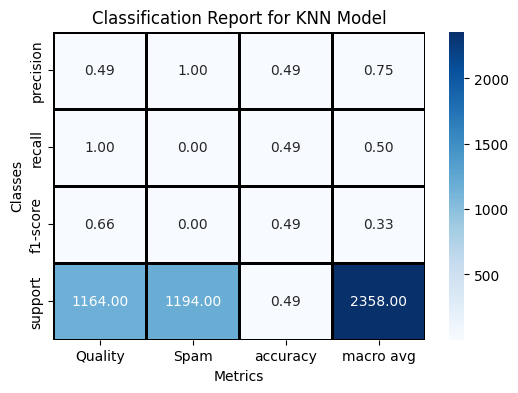

In [59]:
# Map y_test to numerical labels (1 for Quality, 2 for Spam)
label_map = {1: 'Quality', 2: 'Spam'}
y_test_binary = np.vectorize(label_map.get)(y_test)

# Get the classification report as a string
class_report_str = classification_report(y_test_binary, pd.Series(predictions5).map(label_map), target_names=['Quality', 'Spam'])

# Parse the classification report and store the metrics in a DataFrame
class_report_dict = classification_report(y_test_binary, pd.Series(predictions5).map(label_map), target_names=['Quality', 'Spam'], output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report for KNN Model')

Classification Report - KNN:
              precision    recall  f1-score   support

        Real       0.49      1.00      0.66      1164
        Fake       1.00      0.00      0.00      1194

    accuracy                           0.49      2358
   macro avg       0.75      0.50      0.33      2358
weighted avg       0.75      0.49      0.33      2358

Confusion Matrix - KNN:
[[1164    0]
 [1193    1]]




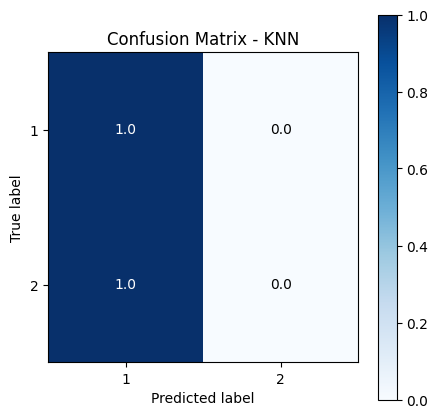

In [60]:
# List of model names
model_names = ['KNN']

# List of predictions for each model
predictions = [predictions5]

# Loop over each model's predictions and generate the classification report and confusion matrix
for model_name, prediction in zip(model_names, predictions):
    print(f'Classification Report - {model_name}:')
    print(classification_report(y_test, prediction, target_names=['Real', 'Fake']))
    
    print(f'Confusion Matrix - {model_name}:')
    cm = confusion_matrix(y_test, prediction)
    print(cm)
    print('\n')
    
    # Visualize the confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True, figsize=(5, 5))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

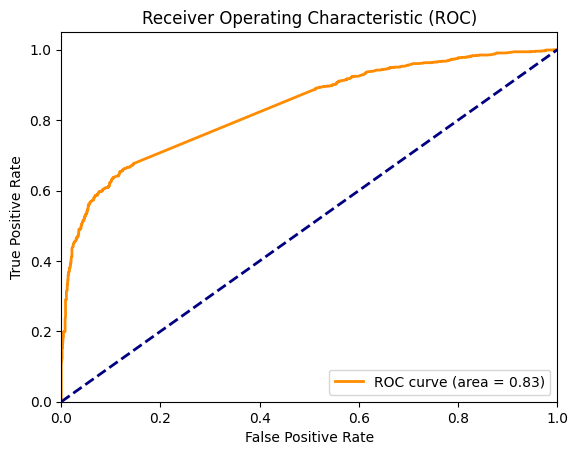

In [61]:
# Convert the y_test labels to {0, 1} format
y_test_binary = (y_test == 2).astype(int)

# Get the predicted probabilities for class 2 (Spam)
predicted_probs = model3.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [62]:
clf6 = DecisionTreeClassifier()

In [63]:
model6 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm='l2')), ('clf', clf6),])

In [64]:
model6.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])

In [65]:
predictions6 = model6.predict(X_test)

In [66]:
accuracy=accuracy_score(y_test,predictions6)

print("Accuracy of Decision Tree Classifier is {:.2f}%".format(accuracy*100))

Accuracy of Decision Tree Classifier is 74.60%


Text(0.5, 1.0, 'Classification Report for Decision Tree Classifier Model')

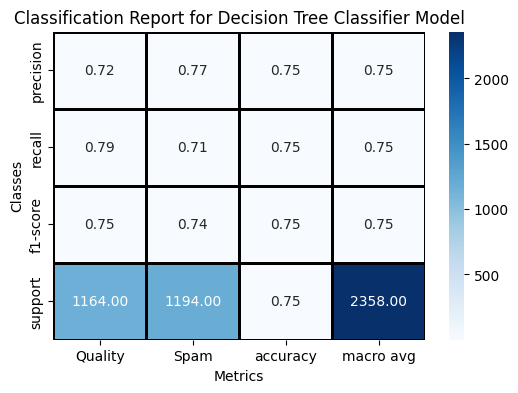

In [67]:
# Map y_test to numerical labels (1 for Quality, 2 for Spam)
label_map = {1: 'Quality', 2: 'Spam'}
y_test_binary = np.vectorize(label_map.get)(y_test)

# Get the classification report as a string
class_report_str = classification_report(y_test_binary, pd.Series(predictions6).map(label_map), target_names=['Quality', 'Spam'])

# Parse the classification report and store the metrics in a DataFrame
class_report_dict = classification_report(y_test_binary, pd.Series(predictions6).map(label_map), target_names=['Quality', 'Spam'], output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report for Decision Tree Classifier Model')

Classification Report - Decision Tree Classifier:
              precision    recall  f1-score   support

        Real       0.72      0.79      0.75      1164
        Fake       0.77      0.71      0.74      1194

    accuracy                           0.75      2358
   macro avg       0.75      0.75      0.75      2358
weighted avg       0.75      0.75      0.75      2358

Confusion Matrix - Decision Tree Classifier:
[[914 250]
 [349 845]]




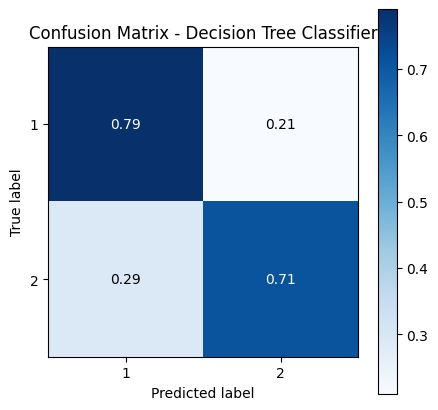

In [68]:
# List of model names
model_names = ['Decision Tree Classifier']

# List of predictions for each model
predictions = [predictions6]

# Loop over each model's predictions and generate the classification report and confusion matrix
for model_name, prediction in zip(model_names, predictions):
    print(f'Classification Report - {model_name}:')
    print(classification_report(y_test, prediction, target_names=['Real', 'Fake']))
    
    print(f'Confusion Matrix - {model_name}:')
    cm = confusion_matrix(y_test, prediction)
    print(cm)
    print('\n')
    
    # Visualize the confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True, figsize=(5, 5))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

In [69]:
# Convert the y_test labels to {0, 1} format
y_test_binary = (y_test == 2).astype(int)

# Get the predicted probabilities for class 2 (Spam)
predicted_probs = model6.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [70]:
clf7 = SVC(kernel='linear')

In [71]:
model7 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm='l2')), ('clf', clf7),])

In [72]:
model7.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel='linear'))])

In [73]:
predictions7 = model7.predict(X_test)

In [74]:
accuracy=accuracy_score(y_test,predictions7)

print("Accuracy of SVC is {:.2f}%".format(accuracy*100))

Accuracy of SVC is 81.30%


In [75]:
# Map y_test to numerical labels (1 for Quality, 2 for Spam)
label_map = {1: 'Quality', 2: 'Spam'}
y_test_binary = np.vectorize(label_map.get)(y_test)

# Get the classification report as a string
class_report_str = classification_report(y_test_binary, pd.Series(predictions7).map(label_map), target_names=['Quality', 'Spam'])

# Parse the classification report and store the metrics in a DataFrame
class_report_dict = classification_report(y_test_binary, pd.Series(predictions7).map(label_map), target_names=['Quality', 'Spam'], output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(class_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report for SVC Model')

Text(0.5, 1.0, 'Classification Report for SVC Model')

Classification Report - SVC:
              precision    recall  f1-score   support

        Real       0.79      0.85      0.82      1164
        Fake       0.84      0.77      0.81      1194

    accuracy                           0.81      2358
   macro avg       0.82      0.81      0.81      2358
weighted avg       0.82      0.81      0.81      2358

Confusion Matrix - SVC:
[[993 171]
 [270 924]]




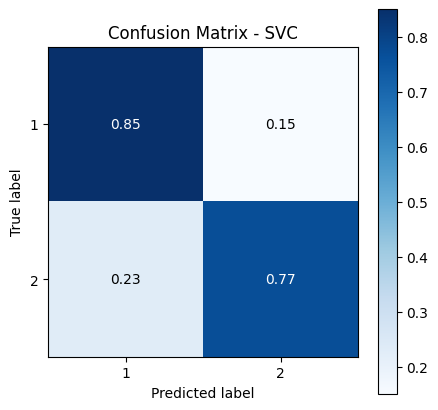

In [76]:
# List of model names
model_names = ['SVC']

# List of predictions for each model
predictions = [predictions7]

# Loop over each model's predictions and generate the classification report and confusion matrix
for model_name, prediction in zip(model_names, predictions):
    print(f'Classification Report - {model_name}:')
    print(classification_report(y_test, prediction, target_names=['Real', 'Fake']))
    
    print(f'Confusion Matrix - {model_name}:')
    cm = confusion_matrix(y_test, prediction)
    print(cm)
    print('\n')
    
    # Visualize the confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True, figsize=(5, 5))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

In [77]:
# Create the SVC model
clf7 = SVC(kernel='linear')

# Fit the model to the training data
model7 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(norm='l2')), ('clf', clf7),])
model7.fit(X_train, y_train)

# Make predictions on the test data
predictions7 = model7.predict(X_test)

# Convert y_test and predictions to binary format (0 or 1)
y_test_binary = (y_test == 2).astype(int)
predictions7_binary = (predictions7 == 2).astype(int)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, model7.decision_function(X_test))

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [78]:
# Convert class labels to one-hot encoded vectors
y_train = to_categorical(y_train - 1)
y_test = to_categorical(y_test - 1)

# Tokenize the text data and convert to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_seq_length = 100  # You can adjust this based on your data and requirements
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')

# Build the BiLSTM model with enhancements
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_seq_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))  # Adding dropout to reduce overfitting
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))  # Adding dropout to reduce overfitting
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(2, activation='softmax'))  # Change the output dimension to 2 for two classes

# Compile the model with a lower learning rate
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add a learning rate scheduler
from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with the learning rate scheduler
model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[lr_scheduler])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("Accuracy of BiLSTM model is {:.2f}%".format(accuracy * 100))

Metal device set to: Apple M2
Epoch 1/10
236/236 [==============================] - 26s 100ms/step - loss: 0.7310 - accuracy: 0.7360 - val_loss: 0.4390 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 2/10
236/236 [==============================] - 21s 88ms/step - loss: 0.1757 - accuracy: 0.9454 - val_loss: 0.4429 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 3/10
236/236 [==============================] - 20s 87ms/step - loss: 0.0359 - accuracy: 0.9916 - val_loss: 0.7846 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 4/10
236/236 [==============================] - 22s 92ms/step - loss: 0.0161 - accuracy: 0.9968 - val_loss: 0.9858 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 5/10
236/236 [==============================] - 21s 90ms/step - loss: 0.5628 - accuracy: 0.6362 - val_loss: 0.7113 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 6/10
236/236 [==============================] - 21s 88ms/step - loss: 0.6453 - accuracy: 0.5970 - val_loss: 0.8050 - val_accuracy: 0.7996 - lr: 9.0484e-04
Epoch 7/10
236/236 [===

In [79]:
# Convert one-hot encoded y_test back to binary labels
y_test_binary = np.argmax(y_test, axis=1) + 1

# Calculate predictions for the BiLSTM model
predictions_bilstm = model.predict(X_test_padded)
predictions_bilstm = np.argmax(predictions_bilstm, axis=1) + 1  # Convert one-hot to binary labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, predictions_bilstm)

# Extract True Positives, True Negatives, False Positives, and False Negatives from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate evaluation metrics
accuracy_bilstm = accuracy_score(y_test_binary, predictions_bilstm) * 100
recall_bilstm = recall_score(y_test_binary, predictions_bilstm, pos_label=2) * 100
f1_bilstm = f1_score(y_test_binary, predictions_bilstm, pos_label=2) * 100
precision_bilstm = precision_score(y_test_binary, predictions_bilstm, pos_label=2) * 100
negative_recall_bilstm = recall_score(y_test_binary, predictions_bilstm, pos_label=1) * 100

# Print the evaluation metrics
print("Evaluation Parameter Values for BiLSTM Model:")
print("Accuracy: {:.2f}%".format(accuracy_bilstm))
print("Recall (Spam Class): {:.2f}%".format(recall_bilstm))
print("F1-Score (Spam Class): {:.2f}%".format(f1_bilstm))
print("Precision (Spam Class): {:.2f}%".format(precision_bilstm))
print("Negative Recall (Real Class): {:.2f}%".format(negative_recall_bilstm))

# Classification Report
target_names = ['Real', 'Spam']
print("\nClassification Report:")
print(classification_report(y_test_binary, predictions_bilstm, target_names=target_names))

74/74 [==============================] - 3s 25ms/step
Evaluation Parameter Values for BiLSTM Model:
Accuracy: 74.64%
Recall (Spam Class): 73.12%
F1-Score (Spam Class): 74.49%
Precision (Spam Class): 75.91%
Negative Recall (Real Class): 76.20%

Classification Report:
              precision    recall  f1-score   support

        Real       0.73      0.76      0.75      1164
        Spam       0.76      0.73      0.74      1194

    accuracy                           0.75      2358
   macro avg       0.75      0.75      0.75      2358
weighted avg       0.75      0.75      0.75      2358



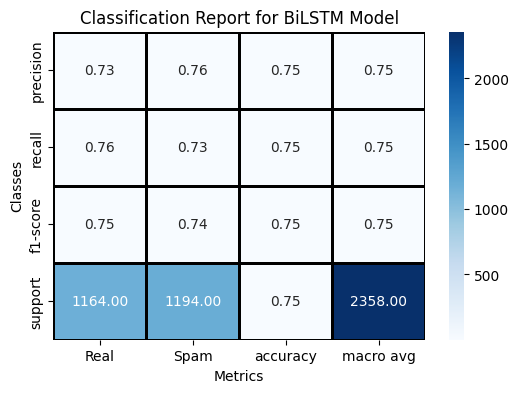

In [80]:
# Classification Report
classification_rep = classification_report(y_test_binary, predictions_bilstm, target_names=target_names, output_dict=True)
classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Plot the classification report
plt.figure(figsize=(6, 4))
sns.heatmap(classification_rep_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", linewidths=1, linecolor='black')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report for BiLSTM Model')
plt.show()

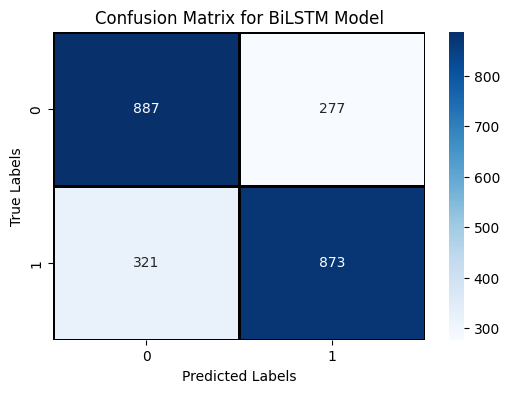

In [81]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for BiLSTM Model')
plt.show()

74/74 [==============================] - 2s 24ms/step


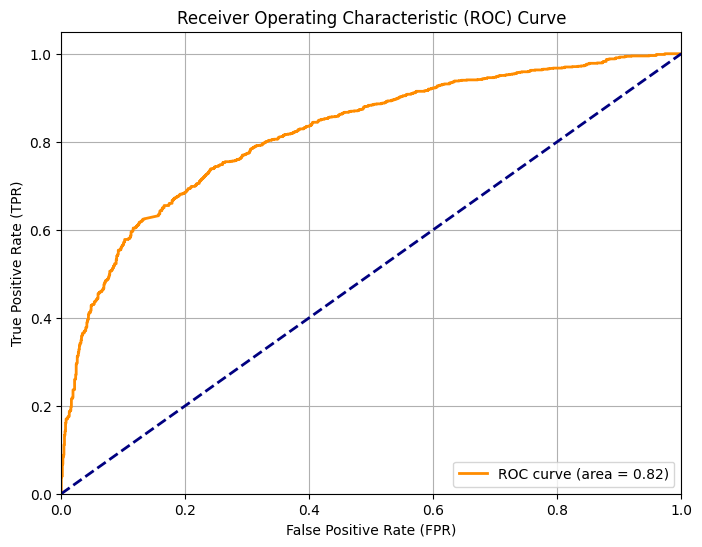

In [82]:
# Make predictions on the test set
predictions_bilstm_prob = model.predict(X_test_padded)

# Convert the predictions to binary labels
predictions_bilstm_binary = np.argmax(predictions_bilstm_prob, axis=1) + 1

# Get the probability of the positive class (Spam class)
predictions_bilstm_prob_spam = predictions_bilstm_prob[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, predictions_bilstm_prob_spam, pos_label=2)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [83]:
# Build the CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_seq_length))
model_cnn.add(Conv1D(128, 5, activation='relu'))  # Convolution layer with 128 filters of size 5
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(2, activation='softmax'))

# Compile the CNN model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN model
model_cnn.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[lr_scheduler])

# Evaluate the CNN model on the test set
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test_padded, y_test)
print("Accuracy of CNN model is {:.2f}%".format(accuracy_cnn * 100))

Epoch 1/10
236/236 [==============================] - 9s 36ms/step - loss: 0.7513 - accuracy: 0.7286 - val_loss: 0.4310 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 2/10
236/236 [==============================] - 8s 34ms/step - loss: 0.1974 - accuracy: 0.9401 - val_loss: 0.4586 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 3/10
236/236 [==============================] - 8s 35ms/step - loss: 0.0420 - accuracy: 0.9948 - val_loss: 0.4924 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 4/10
236/236 [==============================] - 7s 31ms/step - loss: 0.0175 - accuracy: 0.9995 - val_loss: 0.5062 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 5/10
236/236 [==============================] - 7s 31ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.5097 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 6/10
236/236 [==============================] - 8s 32ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.5200 - val_accuracy: 0.8208 - lr: 9.0484e-04
Epoch 7/10
236/236 [==============================] - 8s 34m

74/74 [==============================] - 0s 3ms/step
Classification Report for CNN Model:
              precision    recall  f1-score   support

        Real       0.76      0.85      0.80      1164
        Spam       0.83      0.74      0.78      1194

    accuracy                           0.79      2358
   macro avg       0.80      0.79      0.79      2358
weighted avg       0.80      0.79      0.79      2358



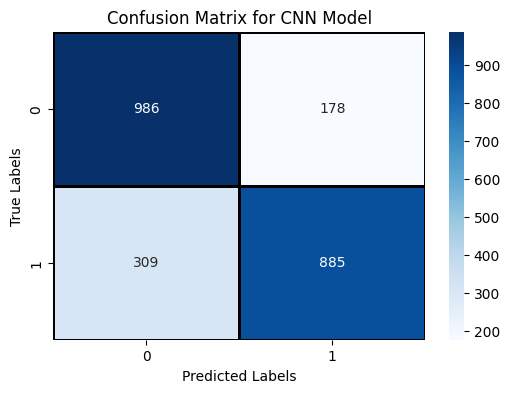

In [84]:
# Calculate predictions for the CNN model
predictions_cnn = model_cnn.predict(X_test_padded)
predictions_cnn = np.argmax(predictions_cnn, axis=1) + 1  # Convert one-hot to binary labels

# Classification Report
target_names = ['Real', 'Spam']
print("Classification Report for CNN Model:")
print(classification_report(y_test_binary, predictions_cnn, target_names=target_names))

# Confusion Matrix
conf_matrix_cnn = confusion_matrix(y_test_binary, predictions_cnn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CNN Model')
plt.show()

74/74 [==============================] - 0s 2ms/step


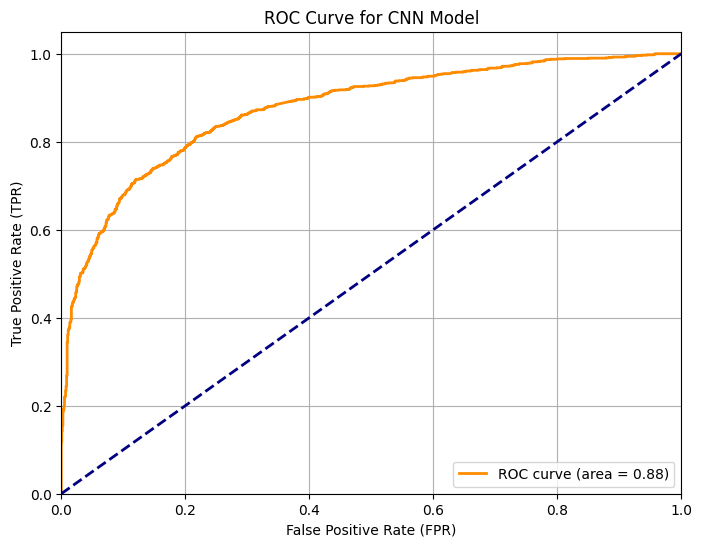

In [85]:
# ROC Curve
predictions_cnn_prob = model_cnn.predict(X_test_padded)
predictions_cnn_prob_spam = predictions_cnn_prob[:, 1]
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_binary, predictions_cnn_prob_spam, pos_label=2)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cnn))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for CNN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [86]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_seq_length))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model_lstm.add(Dense(2, activation='softmax'))

# Compile the LSTM model
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
model_lstm.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[lr_scheduler])

# Evaluate the LSTM model on the test set
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_padded, y_test)
print("Accuracy of LSTM model is {:.2f}%".format(accuracy_lstm * 100))

Epoch 1/10
236/236 [==============================] - 12s 47ms/step - loss: 0.8821 - accuracy: 0.5030 - val_loss: 0.6976 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 2/10
236/236 [==============================] - 9s 40ms/step - loss: 0.6938 - accuracy: 0.5056 - val_loss: 0.6926 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 3/10
236/236 [==============================] - 8s 36ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6926 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 4/10
236/236 [==============================] - 8s 36ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6924 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 5/10
236/236 [==============================] - 9s 36ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6925 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 6/10
236/236 [==============================] - 8s 35ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6924 - val_accuracy: 0.5265 - lr: 9.0484e-04
Epoch 7/10
236/236 [==============================] - 8s 36

74/74 [==============================] - 1s 8ms/step
Classification Report for LSTM Model:
              precision    recall  f1-score   support

        Real       0.49      1.00      0.66      1164
        Spam       0.00      0.00      0.00      1194

    accuracy                           0.49      2358
   macro avg       0.25      0.50      0.33      2358
weighted avg       0.24      0.49      0.33      2358



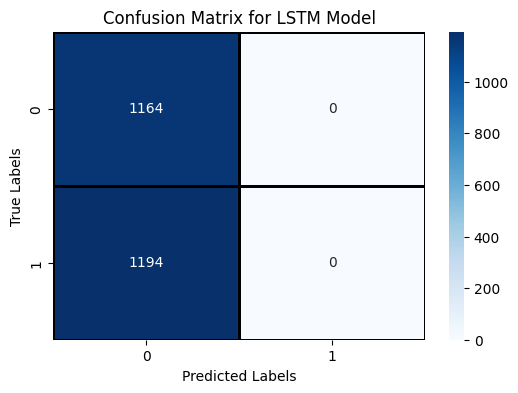

In [87]:
# Calculate predictions for the LSTM model
predictions_lstm = model_lstm.predict(X_test_padded)
predictions_lstm = np.argmax(predictions_lstm, axis=1) + 1  # Convert one-hot to binary labels

# Classification Report
print("Classification Report for LSTM Model:")
print(classification_report(y_test_binary, predictions_lstm, target_names=target_names))

# Confusion Matrix
conf_matrix_lstm = confusion_matrix(y_test_binary, predictions_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

74/74 [==============================] - 1s 7ms/step


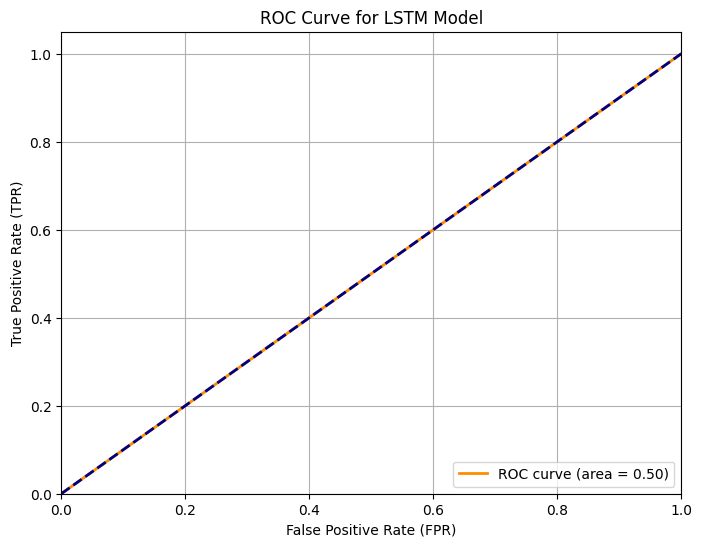

In [88]:
# ROC Curve
predictions_lstm_prob = model_lstm.predict(X_test_padded)
predictions_lstm_prob_spam = predictions_lstm_prob[:, 1]
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_binary, predictions_lstm_prob_spam, pos_label=2)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_lstm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [89]:
# Define algorithm names
algorithm_names = ['Naive Bayes', 'Logistic Regression', 'XGB Classifier', 'RandomForestClassifier', 'KNN', 'DecisionTreeClassifier', 'SVC', 'BiLSTM', 'CNN', 'LSTM']

# Define the predictions variables for each algorithm
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)

# List of accuracy scores for each algorithm (including BiLSTM)
accuracy_scores = [accuracy_score(y_test_binary, predictions1) * 100,
                   accuracy_score(y_test_binary, predictions2) * 100,
                   accuracy_score(y_test_binary, predictions3) * 100,
                   accuracy_score(y_test_binary, predictions4) * 100,
                   accuracy_score(y_test_binary, predictions5) * 100,
                   accuracy_score(y_test_binary, predictions6) * 100,
                   accuracy_score(y_test_binary, predictions7) * 100,
                   accuracy_bilstm, accuracy_cnn * 100, accuracy_lstm * 100]

# List of recall scores for each algorithm (including BiLSTM)
recall_scores = [recall_score(y_test_binary, predictions1, pos_label=2) * 100,
                 recall_score(y_test_binary, predictions2, pos_label=2) * 100,
                 recall_score(y_test_binary, predictions3, pos_label=2) * 100,
                 recall_score(y_test_binary, predictions4, pos_label=2) * 100,
                 recall_score(y_test_binary, predictions5, pos_label=2) * 100,
                 recall_score(y_test_binary, predictions6, pos_label=2) * 100,
                 recall_score(y_test_binary, predictions7, pos_label=2) * 100,
                 recall_bilstm, recall_score(y_test_binary, predictions_cnn, pos_label=2) * 100,
    recall_score(y_test_binary, predictions_lstm, pos_label=2) * 100]

# List of F1-score scores for each algorithm (including BiLSTM)
f1_scores = [f1_score(y_test_binary, predictions1, pos_label=2) * 100,
             f1_score(y_test_binary, predictions2, pos_label=2) * 100,
             f1_score(y_test_binary, predictions3, pos_label=2) * 100,
             f1_score(y_test_binary, predictions4, pos_label=2) * 100,
             f1_score(y_test_binary, predictions5, pos_label=2) * 100,
             f1_score(y_test_binary, predictions6, pos_label=2) * 100,
             f1_score(y_test_binary, predictions7, pos_label=2) * 100,
             f1_bilstm, f1_score(y_test_binary, predictions_cnn, pos_label=2) * 100,
    f1_score(y_test_binary, predictions_lstm, pos_label=2) * 100]

# List of precision scores for each algorithm (including BiLSTM)
precision_scores = [precision_score(y_test_binary, predictions1, pos_label=2) * 100,
                    precision_score(y_test_binary, predictions2, pos_label=2) * 100,
                    precision_score(y_test_binary, predictions3, pos_label=2) * 100,
                    precision_score(y_test_binary, predictions4, pos_label=2) * 100,
                    precision_score(y_test_binary, predictions5, pos_label=2) * 100,
                    precision_score(y_test_binary, predictions6, pos_label=2) * 100,
                    precision_score(y_test_binary, predictions7, pos_label=2) * 100,
                    precision_bilstm, precision_score(y_test_binary, predictions_cnn, pos_label=2) * 100,
    precision_score(y_test_binary, predictions_lstm, pos_label=2) * 100]

# List of negative recall scores for each algorithm (including BiLSTM)
negative_recall_scores = [recall_score(y_test_binary, predictions1, pos_label=1) * 100,
                          recall_score(y_test_binary, predictions2, pos_label=1) * 100,
                          recall_score(y_test_binary, predictions3, pos_label=1) * 100,
                          recall_score(y_test_binary, predictions4, pos_label=1) * 100,
                          recall_score(y_test_binary, predictions5, pos_label=1) * 100,
                          recall_score(y_test_binary, predictions6, pos_label=1) * 100,
                          recall_score(y_test_binary, predictions7, pos_label=1) * 100,
                          negative_recall_bilstm, recall_score(y_test_binary, predictions_cnn, pos_label=1) * 100,
    recall_score(y_test_binary, predictions_lstm, pos_label=1) * 100]

# List of colors for each metric in the line plot
colors = ['blue', 'green', 'red', 'purple', 'orange']

import plotly.graph_objs as go

# Create a plotly figure
fig = go.Figure()

# Add traces for each metric
fig.add_trace(go.Scatter(x=algorithm_names, y=accuracy_scores, mode='lines+markers+text', name='Accuracy', text=[f"{i:.2f}" for i in accuracy_scores], textposition='top center'))
fig.add_trace(go.Scatter(x=algorithm_names, y=recall_scores, mode='lines+markers+text', name='Recall', text=[f"{i:.2f}" for i in recall_scores], textposition='top center'))
fig.add_trace(go.Scatter(x=algorithm_names, y=f1_scores, mode='lines+markers+text', name='F1-score', text=[f"{i:.2f}" for i in f1_scores], textposition='top center'))
fig.add_trace(go.Scatter(x=algorithm_names, y=precision_scores, mode='lines+markers+text', name='Precision', text=[f"{i:.2f}" for i in precision_scores], textposition='top center'))
fig.add_trace(go.Scatter(x=algorithm_names, y=negative_recall_scores, mode='lines+markers+text', name='Negative Recall', text=[f"{i:.2f}" for i in negative_recall_scores], textposition='top center'))

# Update layout
fig.update_layout(title='Algorithm Performance Measures Comparison', xaxis_title='Algorithm', yaxis_title='Performance (%)', xaxis_tickangle=-45)

# Show the plot
fig.show()
